## 8.5.5 使用现代网络提升网络性能
使用DenseNet模型，性能达到90%，有大幅度提升！

## 1.导入模块

In [1]:
import os
import math
import numpy as np
import pickle as p
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

## 2.定义加载函数

In [2]:
def load_CIFAR_data(data_dir):
    """导入CIFAR数据集"""
 
    images_train=[]
    labels_train=[]
    for i in range(5):
        f=os.path.join(data_dir,'data_batch_%d' % (i+1))
        print('loading ',f)
        # 调用 load_CIFAR_batch( )获得批量的图像及其对应的标签
        image_batch,label_batch=load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain=np.concatenate(images_train)
        Ytrain=np.concatenate(labels_train)
        del image_batch ,label_batch
    
    Xtest,Ytest=load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    # 返回训练集的图像和标签，测试集的图像和标签
    return (Xtrain,Ytrain),(Xtest,Ytest)

## 3.定义批量加载函数

In [3]:
def load_CIFAR_batch(filename):
    """ 批量加载数据集 """  
    with open(filename, 'rb')as f:
        data_dict = p.load(f, encoding='bytes')
        images= data_dict[b'data']
        labels = data_dict[b'labels']
                
        # 把原始数据结构调整为: BCWH
        images = images.reshape(10000, 3, 32, 32)
        # tensorflow处理图像数据的结构：BWHC
        # 把通道数据C移动到最后一个维度
        images = images.transpose (0,2,3,1)
     
        labels = np.array(labels)
        
        return images, labels

## 4.运行加载函数

In [4]:
data_dir = r'..\data\cifar-10-batches-py'
(x_train,y_train),(x_test,y_test) = load_CIFAR_data(data_dir)

loading  ..\data\cifar-10-batches-py\data_batch_1
loading  ..\data\cifar-10-batches-py\data_batch_2
loading  ..\data\cifar-10-batches-py\data_batch_3
loading  ..\data\cifar-10-batches-py\data_batch_4
loading  ..\data\cifar-10-batches-py\data_batch_5
finished loadding CIFAR-10 data


## 5.可视化加载数据

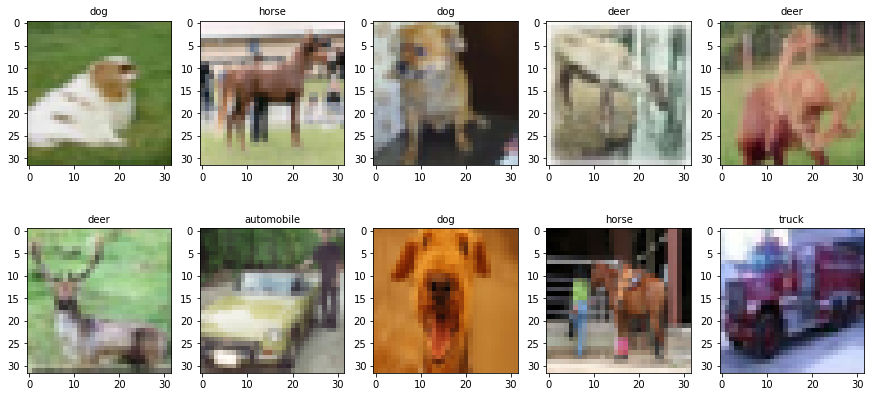

In [5]:
label_dict = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer",
              5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}


def plot_images_labels(images, labels, num):
    total = len(images)
    fig = plt.gcf()
    fig.set_size_inches(15, math.ceil(num / 10) * 7)
    for i in range(0, num):
        choose_n = np.random.randint(0, total)
        
        ax = plt.subplot(math.ceil(num / 5), 5, 1 + i)
        ax.imshow(images[choose_n], cmap='binary')
        title = label_dict[labels[choose_n]]
        ax.set_title(title, fontsize=10)        
    plt.show()
    
plot_images_labels(x_train, y_train, 10)

## 6.对数据进行预处理

In [6]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

train_num = len(x_train)
num_classes = 10

learning_rate = 0.0002
batch_size = 64
training_steps = 20000
display_step = 1000

conv1_filters = 32
conv2_filters = 64
fc1_units = 256


random_normal = tf.initializers.RandomNormal()
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#train_data = train_data.shuffle(5000).repeat(training_steps).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### 数据增强

In [7]:
def convert(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label
 
def augment(image, label):
    image, label = convert(image, label)
    #image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_crop_or_pad(image, 34,34) # 四周各加3像素
    image = tf.image.random_crop(image, size=[32,32,3]) # 随机裁剪成28*28大小
    image = tf.image.random_brightness(image, max_delta=0.5) # 随机增加亮度
    return image, label
 
batch_size = 64

augmented_train_batches = (train_data
                          #.take(num_examples)
                          .cache()
                         # .repeat()
                          .shuffle(5000)
                          .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(batch_size)
                          .prefetch(tf.data.experimental.AUTOTUNE))
 
 
#validation_batches = (test_dataset 
#                     .map(convert, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#                     .batch(2*batch_size))


## 6.定义网络层

In [8]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

import time as time
import numpy as np
import tensorflow.keras.preprocessing.image as image
import matplotlib.pyplot as plt
import os

In [9]:
def dense_block(x, blocks, name, growth_rate = 32):
    for i in range(blocks):
        x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1))
    return x

def transition_block(x, reduction, name):
    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5,name=name + '_bn')(x)
    x = layers.Activation('relu', name=name + '_relu')(x)
    filter = x.shape[3]
    x = layers.Conv2D(int(filter*reduction), 1,use_bias=False,name=name + '_conv')(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    return x

def conv_block(x, growth_rate, name):
    x1 = layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x)
    x1 = layers.Activation('relu')(x1)
    x1 = layers.Conv2D(2 * growth_rate, 1,use_bias=False, name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=3, epsilon=1.001e-5)(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3 ,padding='same',use_bias=False, name=name + '_2_conv')(x1)
    x = layers.Concatenate( name=name + '_concat')([x, x1])
    return x

In [10]:
def my_densenet():
    inputs = keras.Input(shape=(32, 32, 3), name='img')
    x = layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    blocks = [4,8,16]
    x = dense_block(x, blocks[0], name='conv1',growth_rate =32)
    x = transition_block(x, 0.5, name='pool1')
    x = dense_block(x, blocks[1], name='conv2',growth_rate =32)
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[2], name='conv3',growth_rate =32)
    x = transition_block(x, 0.5, name='pool3')
    x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name='bn')(x)
    x = layers.Activation('relu', name='relu')(x)

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.Dense(10, activation='softmax', name='fc1000')(x)

    model = keras.Model(inputs, x, name='densenet121')
    return model
def my_model():
    denseNet = my_densenet()

    denseNet.compile(optimizer=keras.optimizers.Adam(),
                 loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    denseNet.summary()
    return denseNet


In [20]:
current_max_loss = 10000

weight_file='./weights/model.h5'

In [27]:
def train_my_model(deep_model):
    #(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    train_datagen = image.ImageDataGenerator(
        rescale=1 / 255,
        rotation_range=40,  # 角度值，0-180.表示图像随机旋转的角度范围
        width_shift_range=0.2,  # 平移比例，下同
        height_shift_range=0.2,
        shear_range=0.2,  # 随机错切变换角度
        zoom_range=0.2,  # 随即缩放比例
        horizontal_flip=True,  # 随机将一半图像水平翻转
        fill_mode='nearest'  # 填充新创建像素的方法
    )

    test_datagen = image.ImageDataGenerator(rescale=1 / 255)

    validation_datagen = image.ImageDataGenerator(rescale=1 / 255)

    train_generator = train_datagen.flow(x_train[:45000], y_train[:45000], batch_size=32)
    # train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
    validation_generator = validation_datagen.flow(x_train[45000:], y_train[45000:], batch_size=32)

    test_generator = test_datagen.flow(x_test, y_test, batch_size=32)

    begin_time = time.time()

    if os.path.isfile(weight_file):
        print('load weight')
        deep_model.load_weights(weight_file)


    def save_weight(epoch, logs):
        global current_max_loss
        if(logs['val_loss'] is not None and  logs['val_loss']< current_max_loss):
            current_max_loss = logs['val_loss']
            print('save_weight', epoch, current_max_loss)
            deep_model.save_weights(weight_file)

    batch_print_callback = keras.callbacks.LambdaCallback(
        on_epoch_end=save_weight
    )
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='loss'),
        batch_print_callback,
        # keras.callbacks.ModelCheckpoint('./weights/model.h5', save_best_only=True),
        tf.keras.callbacks.TensorBoard(log_dir='logs')
    ]

    print(train_generator[0][0].shape)
    #######修改
    history = deep_model.fit(train_generator, batch_size=32, epochs=100, callbacks=callbacks,
                                       validation_data=validation_generator, validation_steps=39, initial_epoch = 0)
    
    if (history.history['val_loss'] is not None and history.history['val_loss'] < current_max_loss):
       
        current_max_loss = history['val_loss']
        print('save_weight', current_max_loss)
        deep_model.save_weights(weight_file)
    #######修改
    result = deep_model.evaluate(test_generator, verbose=2)

    print(result)
    print('time', time.time() - begin_time)

    def show_result(history):
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.plot(history.history['sparse_categorical_accuracy'])
        plt.plot(history.history['val_sparse_categorical_accuracy'])
        plt.legend(['loss', 'val_loss', 'sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'],
                   loc='upper left')
        plt.show()
        print(history)

    show_result(history)

In [28]:
def test_module(deep_model):
    #(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

    test_datagen = image.ImageDataGenerator(rescale=1 / 255)


    test_generator = test_datagen.flow(x_test, y_test, batch_size=128)

    begin_time = time.time()

    if os.path.isfile(weight_file):
        print('load weight')
        deep_model.load_weights(weight_file)

    result = deep_model.evaluate(test_generator, verbose=2)

    print(result)
    print('time', time.time() - begin_time)

In [29]:
def predict_module(deep_model):
    #x_train, y_train, x_test, y_test = image_augment.get_all_train_data(False)
    
    if os.path.isfile(weight_file):
        print('load weight')
        deep_model.load_weights(weight_file)

    print(y_test[0:20])
    for i in range(20):
        img = x_test[i][np.newaxis, :]/255

        y_ = deep_model.predict(img)
        v  = np.argmax(y_)
        print(v, y_test[i])

### 训练模型

In [30]:
deep_model = my_model()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 16)   448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_114 (BatchN (None, 32, 32, 16)   64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_115 (BatchN (None, 32, 32, 16)   64          batch_normalization_114[0][0]    
________________________________________________________________________________________

In [31]:
train_my_model(deep_model)

load weight
(32, 32, 32, 3)
Epoch 1/100
1407/1407 [==============================] - 89s 60ms/step - loss: 0.5313 - sparse_categorical_accuracy: 0.8180 - val_loss: 57.5287 - val_sparse_categorical_accuracy: 0.0946
save_weight 0 57.52867126464844
Epoch 2/100
1407/1407 [==============================] - 76s 54ms/step - loss: 0.5038 - sparse_categorical_accuracy: 0.8241 - val_loss: 16.9562 - val_sparse_categorical_accuracy: 0.0841
save_weight 1 16.956172943115234
Epoch 3/100
1407/1407 [==============================] - 77s 55ms/step - loss: 0.5013 - sparse_categorical_accuracy: 0.8272 - val_loss: 28.7190 - val_sparse_categorical_accuracy: 0.0946
Epoch 4/100
1407/1407 [==============================] - 77s 55ms/step - loss: 0.4736 - sparse_categorical_accuracy: 0.8376 - val_loss: 13.8332 - val_sparse_categorical_accuracy: 0.0889
save_weight 3 13.833183288574219
Epoch 5/100
1407/1407 [==============================] - 78s 56ms/step - loss: 0.4539 - sparse_categorical_accuracy: 0.8427 - val_

Epoch 44/100
1407/1407 [==============================] - 80s 57ms/step - loss: 0.1838 - sparse_categorical_accuracy: 0.9355 - val_loss: 15.2280 - val_sparse_categorical_accuracy: 0.0889
Epoch 45/100
1407/1407 [==============================] - 80s 57ms/step - loss: 0.1705 - sparse_categorical_accuracy: 0.9418 - val_loss: 41.3475 - val_sparse_categorical_accuracy: 0.0529
Epoch 46/100
1407/1407 [==============================] - 80s 57ms/step - loss: 0.1802 - sparse_categorical_accuracy: 0.9355 - val_loss: 5.5078 - val_sparse_categorical_accuracy: 0.1018
Epoch 47/100
1407/1407 [==============================] - 80s 57ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.9363 - val_loss: 4.3379 - val_sparse_categorical_accuracy: 0.1098
Epoch 48/100
1407/1407 [==============================] - 80s 57ms/step - loss: 0.1724 - sparse_categorical_accuracy: 0.9395 - val_loss: 27.6693 - val_sparse_categorical_accuracy: 0.1050
Epoch 49/100
1407/1407 [==============================] - 80s 57ms/

Epoch 88/100
1407/1407 [==============================] - 79s 56ms/step - loss: 0.1151 - sparse_categorical_accuracy: 0.9609 - val_loss: 7.5253 - val_sparse_categorical_accuracy: 0.1571
Epoch 89/100
1407/1407 [==============================] - 79s 56ms/step - loss: 0.1557 - sparse_categorical_accuracy: 0.9455 - val_loss: 8.0850 - val_sparse_categorical_accuracy: 0.1018
Epoch 90/100
1407/1407 [==============================] - 79s 56ms/step - loss: 0.1261 - sparse_categorical_accuracy: 0.9552 - val_loss: 50.0025 - val_sparse_categorical_accuracy: 0.0873


UnboundLocalError: local variable 'current_max_loss' referenced before assignment